In [ ]:
# Standard library
import os
import random
import shutil
from collections import Counter, defaultdict

# Third-party
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')
# https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader

# Setting random seed for reproducibility
def set_seed(seed_value: int = 42) -> None:
    """Set seeds for Python, NumPy, and PyTorch (CPU/CUDA) to improve reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)
# https://www.geeksforgeeks.org/deep-learning/reproducibility-in-pytorch/

# Configs
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATASET_PATH = '/kaggle/input/rp2k-dataset'
IMG_ROOT = os.path.join(DATASET_PATH, 'rp2k_dataset')
META_PATH = os.path.join(DATASET_PATH, 'meta.csv')
BALANCED_DATASET_DIR = '/kaggle/working/rp2k_balanced_200'
# https://www.geeksforgeeks.org/machine-learning/how-to-set-up-and-run-cuda-operations-in-pytorch/

# logger func.
def log(msg: str) -> None:
    """Print an info-prefixed message."""
    print(f'[INFO] {msg}')

log(f'Using device: {DEVICE}')

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda


[INFO] Loading metadata...
[INFO] Loaded 381303 metadata records.


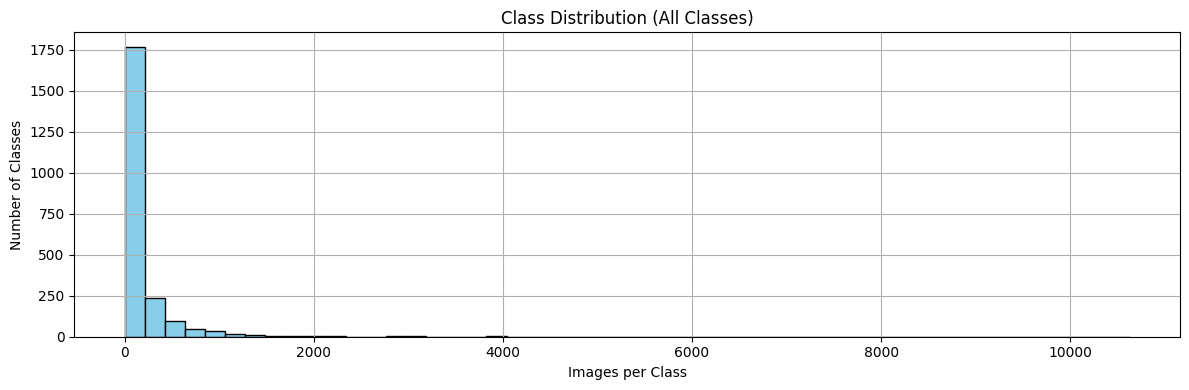

[INFO] Total classes: 2233
[INFO] Classes with >=40 images: 1208
[INFO] Filtered to 1208 classes with >=40 images.
[INFO] Remaining images: 364984


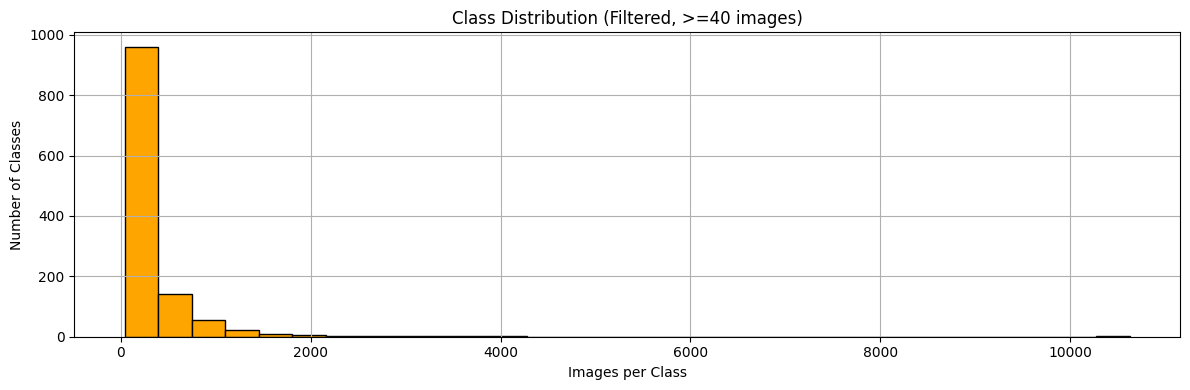

In [ ]:
# 2. Loading and Analyzing Metadata
log('Loading metadata...')
meta = pd.read_csv(META_PATH)
log(f'Loaded {len(meta)} metadata records.')

# Analyzing class distribution
class_counts = meta['instance_id'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 4))
plt.hist(class_counts.values, bins=50, color='skyblue', edgecolor='k')
plt.title('Class Distribution (All Classes)')
plt.xlabel('Images per Class')
plt.ylabel('Number of Classes')
plt.grid(True)
plt.tight_layout()
plt.savefig('class_distribution_all.png')
plt.show()
log(f'Total classes: {class_counts.shape[0]}')
log(f'Classes with >=40 images: {(class_counts >= 40).sum()}')

# 3. Filtering Classes with ≥40 Images
min_images_per_class = 40
valid_classes = class_counts[class_counts >= min_images_per_class].index.tolist()
meta_filtered = meta[meta['instance_id'].isin(valid_classes)].copy()
log(f'Filtered to {len(valid_classes)} classes with >=40 images.')
log(f'Remaining images: {len(meta_filtered)}')

# Visualizing filtered class distribution
filtered_counts = meta_filtered['instance_id'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 4))
plt.hist(filtered_counts.values, bins=30, color='orange', edgecolor='k')
plt.title('Class Distribution (Filtered, >=40 images)')
plt.xlabel('Images per Class')
plt.ylabel('Number of Classes')
plt.grid(True)
plt.tight_layout()
plt.savefig('class_distribution_filtered.png')
plt.show()

# https://www.geeksforgeeks.org/python/how-to-access-the-metadata-of-a-tensor-in-pytorch/
# https://www.geeksforgeeks.org/deep-learning/handling-class-imbalance-in-pytorch/
# https://seaborn.pydata.org/tutorial/distributions.html

[INFO] Preparing balanced sampling...


Sampling per class: 1208it [00:00, 3566.12it/s]


[INFO] Classes with >200 images are downsampled to 200. Others kept for augmentation.
[INFO] Images after sampling: 165293


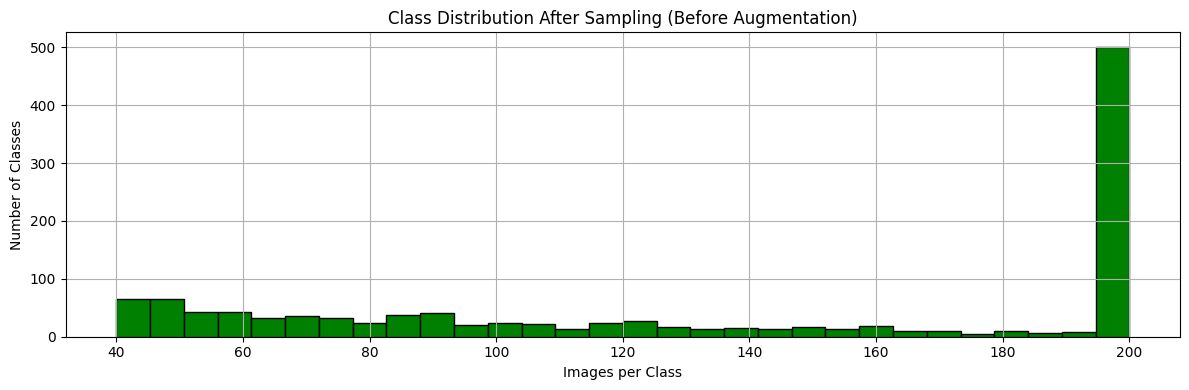

In [ ]:
# Balanced sampling - max 200 images per class
log('Preparing balanced sampling...')
max_images_per_class: int = 200
balanced_meta = []
class_to_images = meta_filtered.groupby('instance_id')['image_path'].apply(list)

for cls, img_list in tqdm(class_to_images.items(), desc='Sampling per class'):
    if len(img_list) > max_images_per_class:
        sampled = random.sample(img_list, max_images_per_class)
        for img in sampled:
            balanced_meta.append({'instance_id': cls, 'image_path': img, 'aug': False})
    else:
        for img in img_list:
            balanced_meta.append({'instance_id': cls, 'image_path': img, 'aug': False})

balanced_meta_df = pd.DataFrame(balanced_meta)
log(f'Classes with >200 images are downsampled to 200. Others kept for augmentation.')
log(f'Images after sampling: {len(balanced_meta_df)}')

# https://www.geeksforgeeks.org/python/apply-operations-to-groups-in-pandas/
# https://www.geeksforgeeks.org/python/python-pandas-dataframe-sample/

# Showing class distribution after sampling
sampled_counts = balanced_meta_df['instance_id'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 4))
plt.hist(sampled_counts.values, bins=30, color='green', edgecolor='k')
plt.title('Class Distribution After Sampling (Before Augmentation)')
plt.xlabel('Images per Class')
plt.ylabel('Number of Classes')
plt.grid(True)
plt.tight_layout()
plt.savefig('class_distribution_sampled.png')
plt.show()
# https://www.w3schools.com/python/matplotlib_histograms.asp

In [ ]:
# Augmenting images for classes with <200 images
log('Augmenting images for classes with <200 images...')

augmented_meta: list = []
AUGS_PER_CLASS: dict = {}

# Defining augmentation pipeline
strong_aug = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=30, p=0.7),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=0, p=0.7),
    A.RandomBrightnessContrast(p=0.7),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.4),
    A.Blur(p=0.3),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.4),
    A.CLAHE(p=0.2),
    A.ToFloat(max_value=255.0),
])
# https://albumentations.ai/docs/

for cls, group in balanced_meta_df.groupby('instance_id'):
    imgs = group['image_path'].tolist()
    n_orig: int = len(imgs)

    if n_orig < max_images_per_class:
        n_needed = max_images_per_class - n_orig
        for i in range(n_needed):
            src_img = random.choice(imgs)
            augmented_meta.append(
                {'instance_id': cls, 'image_path': src_img, 'aug': True, 'aug_idx': i}
            )
        AUGS_PER_CLASS[cls] = n_needed
    else:
        AUGS_PER_CLASS[cls] = 0

log(f'Augmentation plan: {sum(AUGS_PER_CLASS.values())} new images will be generated.')
log(f'Example: {list(AUGS_PER_CLASS.items())[:5]}')
# https://www.geeksforgeeks.org/python/random-choices-method-in-python/

[INFO] Augmenting images for classes with <200 images...
[INFO] Augmentation plan: 76307 new images will be generated.
[INFO] Example: [('555（星空细支）', 147), ('Meco果汁茶桃桃红柚', 151), ('Meco果汁茶泰式青柠', 118), ('SZL白醋蓝', 156), ('others', 0)]


[INFO] Saving balanced dataset (original, sampled, and augmented images)...


Generating augmented images: 100%|██████████| 76307/76307 [26:10<00:00, 48.60it/s]


[INFO] Balanced dataset saved.


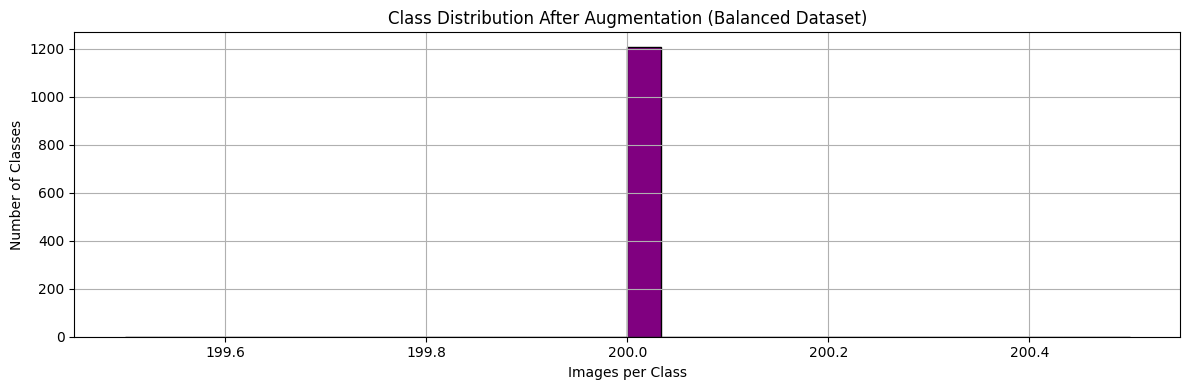

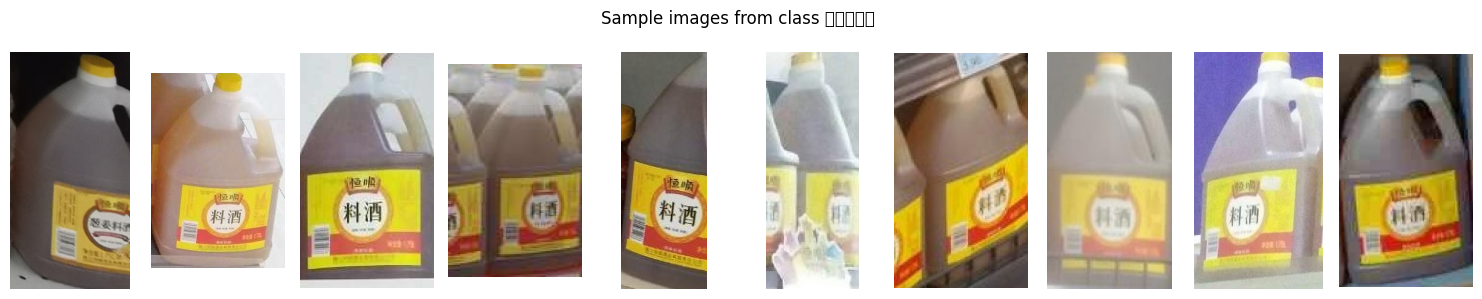

In [ ]:
# Saving balanced dataset (original, sampled and augmented images)
log('Saving balanced dataset (original, sampled and augmented images)...')

if os.path.exists(BALANCED_DATASET_DIR):
    shutil.rmtree(BALANCED_DATASET_DIR)
os.makedirs(BALANCED_DATASET_DIR, exist_ok=True)
# https://www.geeksforgeeks.org/python/python-directory-management/

# Saving original and sampled images
for row in tqdm(balanced_meta, desc='Copying original/sampled images'):
    cls = row['instance_id']
    src = os.path.join(IMG_ROOT, row['image_path'])
    dst_dir = os.path.join(BALANCED_DATASET_DIR, str(cls))
    os.makedirs(dst_dir, exist_ok=True)

    dst = os.path.join(dst_dir, os.path.basename(row['image_path']))
    if not os.path.exists(dst):
        shutil.copy2(src, dst)
# https://www.geeksforgeeks.org/python/python-shutil-copy2-method/

# Saving augmented images with blank check
def is_blank(img: np.ndarray, threshold: int = 5) -> bool:
    """Return True if image mean intensity is below threshold."""
    return np.mean(img) < threshold

for row in tqdm(augmented_meta, desc='Generating augmented images'):
    cls = row['instance_id']
    src = os.path.join(IMG_ROOT, row['image_path'])
    dst_dir = os.path.join(BALANCED_DATASET_DIR, str(cls))
    os.makedirs(dst_dir, exist_ok=True)

    img = cv2.imread(src)
    if img is None:
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for _ in range(5):
        aug_img = strong_aug(image=img)['image']
        aug_img = np.clip(aug_img, 0, 255).astype(np.uint8)
        if not is_blank(aug_img):
            break
    else:
        aug_img = img

    aug_name = f"aug_{row['aug_idx']:03d}_" + os.path.basename(row['image_path'])
    dst = os.path.join(dst_dir, aug_name)
    cv2.imwrite(dst, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
# https://stackoverflow.com/questions/26681756/how-to-convert-a-python-numpy-array-to-an-rgb-image-with-opencv-2-4

log('Balanced dataset saved.')

# Plot class distribution after augmentation
class_counts_after: list[int] = []
for cls in sorted(os.listdir(BALANCED_DATASET_DIR)):
    img_count = len(os.listdir(os.path.join(BALANCED_DATASET_DIR, cls)))
    class_counts_after.append(img_count)

plt.figure(figsize=(12, 4))
plt.hist(class_counts_after, bins=30, color='purple', edgecolor='k')
plt.title('Class Distribution After Augmentation (Balanced Dataset)')
plt.xlabel('Images per Class')
plt.ylabel('Number of Classes')
plt.grid(True)
plt.tight_layout()
plt.savefig('class_distribution_after_augmentation.png')
plt.show()

# Visualizing a few samples from a random class
import random

sample_cls = random.choice(sorted(os.listdir(BALANCED_DATASET_DIR)))
sample_dir = os.path.join(BALANCED_DATASET_DIR, str(sample_cls))
sample_imgs = os.listdir(sample_dir)[:10]

plt.figure(figsize=(15, 3))
for i, img_name in enumerate(sample_imgs):
    img = Image.open(os.path.join(sample_dir, img_name))
    plt.subplot(1, 10, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle(f'Sample images from class {sample_cls}')
plt.tight_layout()
plt.savefig('sample_balanced_class.png')
plt.show()
# https://www.w3schools.com/python/matplotlib_subplot.asp

[INFO] Creating stratified train/validation split...
[INFO] Train images: 205360, Val images: 36240


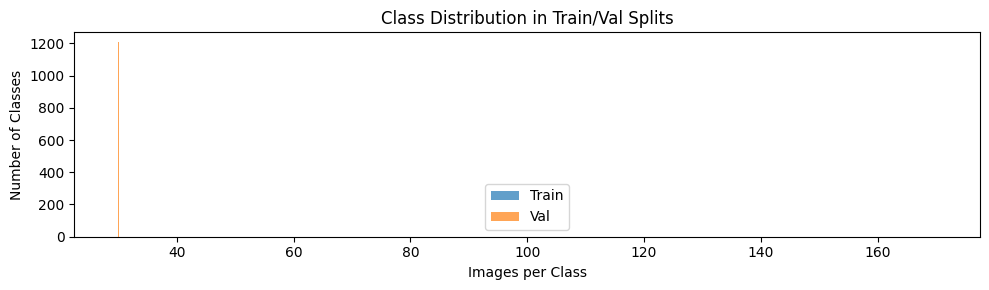

In [ ]:
# 7. Creating Train/Validation Split
log('Creating stratified train/validation split...')

from glob import glob

all_img_paths: list[str] = []
all_labels: list[str] = []

for cls in os.listdir(BALANCED_DATASET_DIR):
    img_files = glob(os.path.join(BALANCED_DATASET_DIR, cls, '*'))
    all_img_paths.extend(img_files)
    all_labels.extend([cls] * len(img_files))

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_img_paths,
    all_labels,
    test_size=0.15,
    stratify=all_labels,
    random_state=SEED
)

log(f'Train images: {len(train_paths)}, Val images: {len(val_paths)}')
# https://www.geeksforgeeks.org/machine-learning/how-to-split-a-dataset-into-train-and-test-sets-using-python/

# Visualizing class distribution in splits
train_counts = pd.Series(train_labels).value_counts()
val_counts = pd.Series(val_labels).value_counts()

plt.figure(figsize=(10, 3))
plt.hist(train_counts.values, bins=20, alpha=0.7, label='Train')
plt.hist(val_counts.values, bins=20, alpha=0.7, label='Val')
plt.title('Class Distribution in Train/Val Splits')
plt.xlabel('Images per Class')
plt.ylabel('Number of Classes')
plt.legend()
plt.tight_layout()
plt.savefig('class_distribution_trainval.png')
plt.show()

[INFO] Defining augmentation pipelines...
[INFO] Visualizing augmentations...


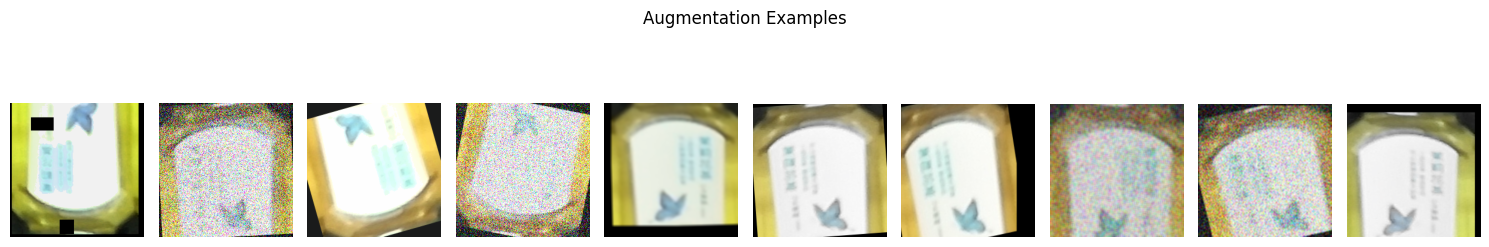

In [ ]:
# 8. Defining Advanced Augmentation Pipeline
log('Defining augmentation pipelines...')

IMG_SIZE: int = 224

def get_train_transform():
    """Return augmentation pipeline for training images."""
    return A.Compose([
        A.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=20, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.4),
        A.GaussNoise(p=0.3),
        A.Blur(p=0.2),
        A.CoarseDropout(
            max_holes=8,
            max_height=IMG_SIZE // 8,
            max_width=IMG_SIZE // 8,
            fill_value=0,
            p=0.3
        ),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_val_transform():
    """Return augmentation pipeline for validation images."""
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
# https://www.datacamp.com/tutorial/complete-guide-data-augmentation

# Visualizing few augmentations
log('Visualizing augmentations...')

example_img = Image.open(train_paths[0]).convert('RGB')
example_img_np = np.array(example_img)

plt.figure(figsize=(15, 3))
for i in range(10):
    aug_img = get_train_transform()(image=example_img_np)['image']
    aug_img = aug_img.permute(1, 2, 0).cpu().numpy()
    aug_img = np.clip((aug_img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)

    plt.subplot(1, 10, i + 1)
    plt.imshow(aug_img)
    plt.axis('off')

plt.suptitle('Augmentation Examples')
plt.tight_layout()
plt.savefig('augmentation_examples.png')
plt.show()

In [ ]:
# 9. Creating custom PyTorch Dataset for Balanced Data
class BalancedRP2KDataset(Dataset):
    """Balanced RP2K dataset wrapper."""
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(set(labels)))}

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.class_to_idx[self.labels[idx]]
        if self.transform:
            img = self.transform(image=img)['image']
        return img, label
# https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Creating datasets and dataloaders
train_dataset = BalancedRP2KDataset(train_paths, train_labels, transform=get_train_transform())
val_dataset = BalancedRP2KDataset(val_paths, val_labels, transform=get_val_transform())

BATCH_SIZE: int = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

log(f'Train/Val datasets and loaders created. Classes: {len(train_dataset.class_to_idx)}')

# https://www.geeksforgeeks.org/python/datasets-and-dataloaders-in-pytorch/


[INFO] Train/Val datasets and loaders created. Classes: 1208


In [ ]:
# 10. Model Selection and Definition
log('Defining model...')

import timm

num_classes: int = len(train_dataset.class_to_idx)

# Using model with available pretrained weights
model = timm.create_model('efficientnetv2_rw_m', pretrained=True, num_classes=num_classes)
model = model.to(DEVICE)
log(f'Model: EfficientNetV2-RW-M, Pretrained, Num classes: {num_classes}')

# https://dataloop.ai/library/model/timm_efficientnetv2_rw_sra2_in1k/

print(model)

[INFO] Defining model...


model.safetensors:   0%|          | 0.00/214M [00:00<?, ?B/s]

[INFO] Model: EfficientNetV2-RW-M, Pretrained, Num classes: 1208
EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pwl): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path

In [ ]:
# 11. Training Loop with Early Stopping, Frequent Checkpoints, and Plots
log('Starting training loop...')

from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score

EPOCHS: int = 4
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = GradScaler()
criterion = nn.CrossEntropyLoss()

best_val_acc: float = 0.0
train_losses: list[float] = []
val_losses: list[float] = []
train_accs: list[float] = []
val_accs: list[float] = []

# Early stopping params
patience: int = 3
es_counter: int = 0
best_epoch: int = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss: float = 0.0
    correct: int = 0
    total: int = 0

    for imgs, labels in tqdm(train_loader, desc=f'Epoch {epoch} [Train]', leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss: float = 0.0
    val_correct: int = 0
    val_total: int = 0
    val_preds: list[int] = []
    val_true: list[int] = []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f'Epoch {epoch} [Val]', leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            with autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += imgs.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    log(f'Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}')
    scheduler.step()

    # Saving best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model_balanced.pth')
        log('Best model saved.')
        es_counter = 0
    else:
        es_counter += 1

    # Save checkpoint every 2 epochs
    if epoch % 2 == 0:
        torch.save(model.state_dict(), f'checkpoint_epoch{epoch}.pth')
        log(f'Checkpoint saved at epoch {epoch}.')

    # Save plots every 2 epochs
    if epoch % 2 == 0 or epoch == EPOCHS or es_counter == patience:
        # Combined loss/acc plot
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.legend()
        plt.title('Loss Curve')

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.legend()
        plt.title('Accuracy Curve')

        plt.tight_layout()
        plt.savefig(f'train_val_curves_epoch{epoch}.png')
        plt.close()

        # Separate plots
        plt.figure()
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.legend()
        plt.title('Loss Curve')
        plt.savefig(f'loss_curve_epoch{epoch}.png')
        plt.close()

        plt.figure()
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.legend()
        plt.title('Accuracy Curve')
        plt.savefig(f'acc_curve_epoch{epoch}.png')
        plt.close()

    # Early stopping
    if es_counter >= patience:
        log(f'Early stopping triggered at epoch {epoch}. Best epoch: {best_epoch}')
        break

# https://machinelearningmastery.com/managing-a-pytorch-training-process-with-checkpoints-and-early-stopping/
# https://medium.com/biased-algorithms/a-practical-guide-to-implementing-early-stopping-in-pytorch-for-model-training-99a7cbd46e9d
# https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html

[INFO] Starting training loop...


[INFO] Epoch 1: Train Loss=0.9346, Train Acc=0.8063, Val Loss=0.7106, Val Acc=0.8184
[INFO] Best model saved.


[INFO] Epoch 2: Train Loss=0.2038, Train Acc=0.9416, Val Loss=0.6810, Val Acc=0.8311
[INFO] Best model saved.
[INFO] Checkpoint saved at epoch 2.


[INFO] Epoch 3: Train Loss=0.1084, Train Acc=0.9672, Val Loss=0.5993, Val Acc=0.8530
[INFO] Best model saved.


[INFO] Epoch 4: Train Loss=0.0553, Train Acc=0.9825, Val Loss=0.5832, Val Acc=0.8586
[INFO] Best model saved.
[INFO] Checkpoint saved at epoch 4.


[INFO] Evaluating best model and visualizing results...


Evaluating on val set: 100%|██████████| 1133/1133 [02:08<00:00,  8.79it/s]


[INFO] Classification report saved as classification_report.csv
Top 10 classes by recall:
黑卡六小时          1.0
555（星空细支）      1.0
Meco果汁茶桃桃红柚    1.0
Meco果汁茶泰式青柠    1.0
黄鹤楼（软蓝）        1.0
黄鹤楼（软三口品）      1.0
一个柠檬茶饮料        1.0
黄鹤楼（硬红）        1.0
七喜组合装          1.0
黄鹤楼（硬天下胜景）     1.0
Name: recall, dtype: float64
Bottom 10 classes by recall:
老恒和浙江黄酒         0.0
北京军功二锅头         0.0
李锦记卤水汁          0.0
李锦记凉拌汁          0.0
海天特级一品鲜500ML    0.0
海天陈醋            0.0
海天香醋            0.0
味达美醇香米醋         0.0
喜力啤酒500ml       0.0
恒顺葱姜料酒          0.0
Name: recall, dtype: float64


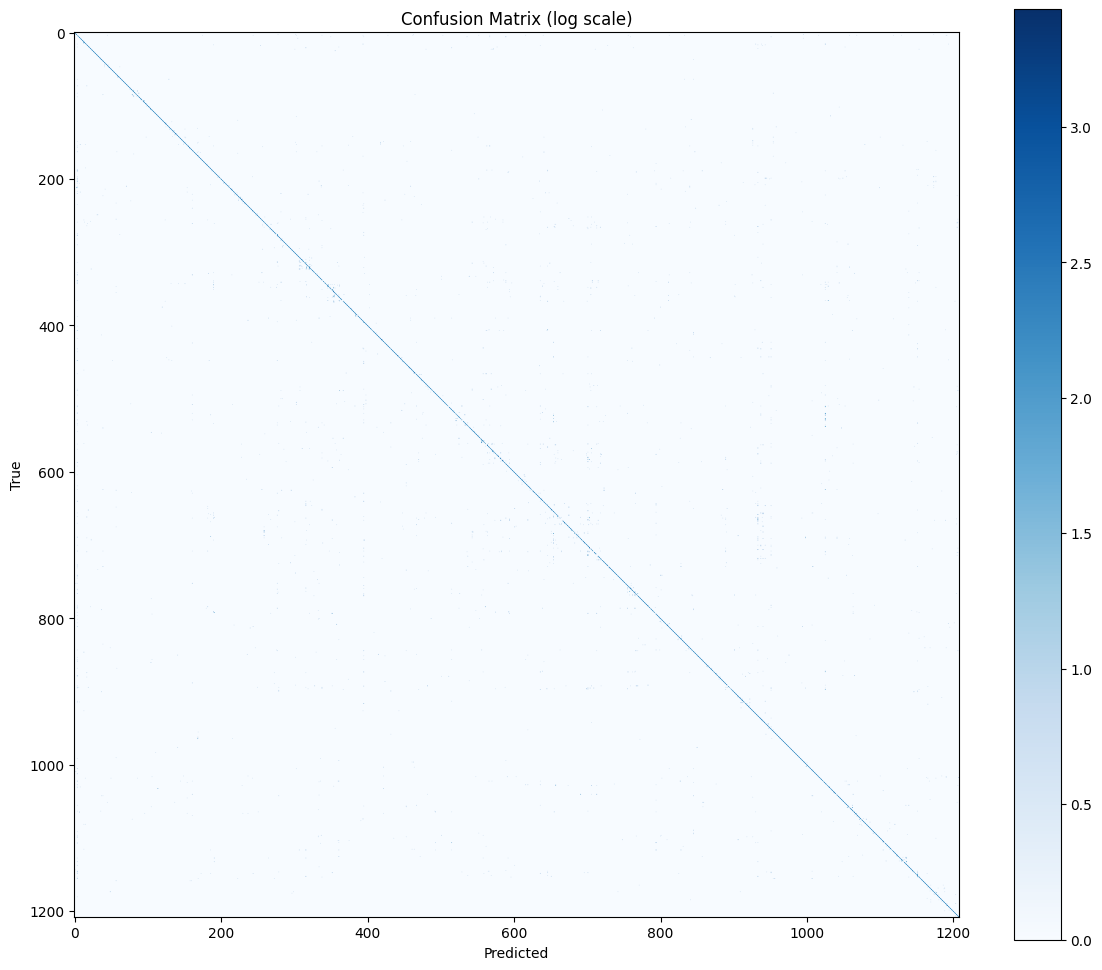

[INFO] Visualizing correct and incorrect predictions...


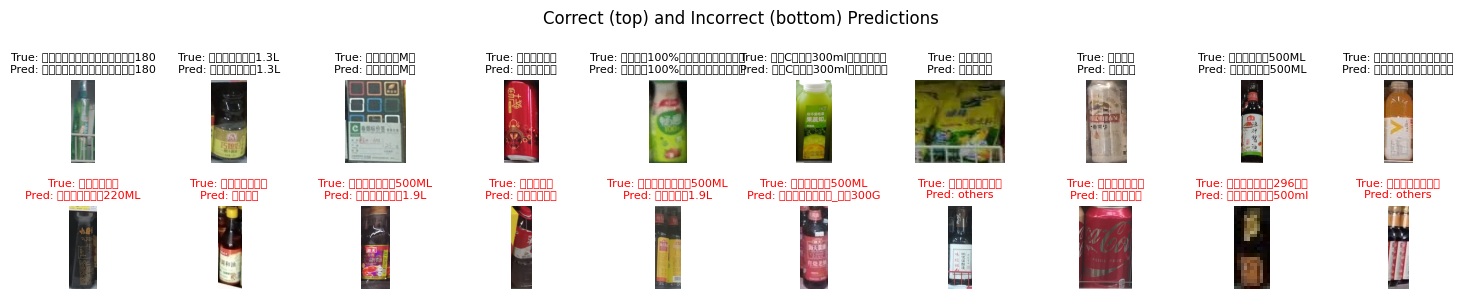

In [ ]:
# 12. Evaluation and plots
log('Evaluating best model and visualizing results...')

from sklearn.metrics import classification_report, confusion_matrix

# Load best model
model.load_state_dict(torch.load('best_model_balanced.pth', map_location=DEVICE))
model.eval()

# Predict on validation set
all_preds: list[int] = []
all_labels: list[int] = []
with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc='Evaluating on val set'):
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Classification report
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
all_labels_str = [idx_to_class[x] for x in all_labels]
all_preds_str = [idx_to_class[x] for x in all_preds]

report = classification_report(
    all_labels_str,
    all_preds_str,
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('classification_report.csv')
log('Classification report saved as classification_report.csv')

# Show top-10 and bottom-10 classes by recall
recalls = report_df.loc[
    ~report_df.index.isin(['accuracy', 'macro avg', 'weighted avg']),
    'recall'
]
top10 = recalls.sort_values(ascending=False).head(10)
bottom10 = recalls.sort_values().head(10)
print('Top 10 classes by recall:')
print(top10)
print('Bottom 10 classes by recall:')
print(bottom10)

# Confusion matrix
cm = confusion_matrix(
    all_labels_str,
    all_preds_str,
    labels=list(train_dataset.class_to_idx.keys())
)
plt.figure(figsize=(12, 10))
plt.imshow(np.log1p(cm), cmap='Blues')
plt.title('Confusion Matrix (log scale)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Visualize some correct and incorrect predictions
log('Visualizing correct and incorrect predictions...')

correct = [i for i, (p, t) in enumerate(zip(all_preds, all_labels)) if p == t]
incorrect = [i for i, (p, t) in enumerate(zip(all_preds, all_labels)) if p != t]

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random.sample(correct, min(10, len(correct)))):
    img = Image.open(val_paths[idx])
    plt.subplot(2, 10, i + 1)
    plt.imshow(img)
    plt.title(f'True: {all_labels_str[idx]}\nPred: {all_preds_str[idx]}', fontsize=8)
    plt.axis('off')

for i, idx in enumerate(random.sample(incorrect, min(10, len(incorrect)))):
    img = Image.open(val_paths[idx])
    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(img)
    plt.title(f'True: {all_labels_str[idx]}\nPred: {all_preds_str[idx]}', fontsize=8, color='red')
    plt.axis('off')

plt.suptitle('Correct (top) and Incorrect (bottom) Predictions')
plt.tight_layout()
plt.savefig('correct_incorrect_examples.png')
plt.show()